In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
# import track coordinates
track_cord = pd.read_csv('web_results/trackCoordinates.csv')

In [3]:
# overall data exploratory analysis
track_cord.head(5)

,t [pixel] #1,x [pixel] #1,t [pixel] #2,x [pixel] #2,t [pixel] #3,x [pixel] #3,t [pixel] #4,x [pixel] #4,t [pixel] #5,x [pixel] #5,...,t [pixel] #31,x [pixel] #31,t [pixel] #32,x [pixel] #32,t [pixel] #33,x [pixel] #33,t [pixel] #34,x [pixel] #34,t [pixel] #35,x [pixel] #35
0,2.0,214.0,38.0,5.0,40.0,121.0,44.0,53.0,128.0,10.0,...,146.0,250.0,274.0,223.0,177.0,250.0,286.0,216.0,174.0,258.0
1,3.0,213.0,39.0,6.0,41.0,122.0,45.0,51.0,129.0,15.0,...,147.0,250.0,275.0,223.0,180.0,259.0,287.0,217.0,175.0,260.0
2,4.0,213.0,40.0,8.0,42.0,124.0,46.0,49.0,130.0,24.0,...,148.0,249.0,276.0,223.0,NaN,NaN,288.0,218.0,176.0,262.0
3,5.0,212.0,41.0,10.0,43.0,124.0,47.0,49.0,131.0,36.0,...,149.0,249.0,277.0,222.0,NaN,NaN,289.0,220.0,177.0,264.0
4,6.0,211.0,42.0,10.0,44.0,124.0,48.0,49.0,132.0,47.0,...,150.0,250.0,278.0,222.0,NaN,NaN,290.0,222.0,178.0,266.0


In [4]:
summary = pd.read_csv('web_results/summary.csv', skiprows=1, index_col=False)

In [5]:
summary.head()

,Direction,Av frame2frame velocity [um/sec],track duration [sec],track total displacement [um],Start2end velocity [um/sec]
0,-1.0,2.0611,132.0,270.0,2.0455
1,-1.0,0.5938,33.0,19.0,0.5758
2,-1.0,2.0255,197.0,397.0,2.0152
3,1.0,2.8382,69.0,193.0,2.7971
4,1.0,10.0000,11.0,100.0,9.0909


In [6]:
# aasign -1.0 to retrograde motion and 1.0 to anterograde motion
summary['direction'] = summary.Direction.map({-1: 'retrograde', 1: 'anterograde'})
summary['track total displacement [um]'] = summary['track total displacement [um]']*summary['Direction']
summary.head()

,Direction,Av frame2frame velocity [um/sec],track duration [sec],track total displacement [um],Start2end velocity [um/sec],direction
0,-1.0,2.0611,132.0,-270.0,2.0455,retrograde
1,-1.0,0.5938,33.0,-19.0,0.5758,retrograde
2,-1.0,2.0255,197.0,-397.0,2.0152,retrograde
3,1.0,2.8382,69.0,193.0,2.7971,anterograde
4,1.0,10.0000,11.0,100.0,9.0909,anterograde


<Axes: xlabel='track total displacement [um]', ylabel='Count'>

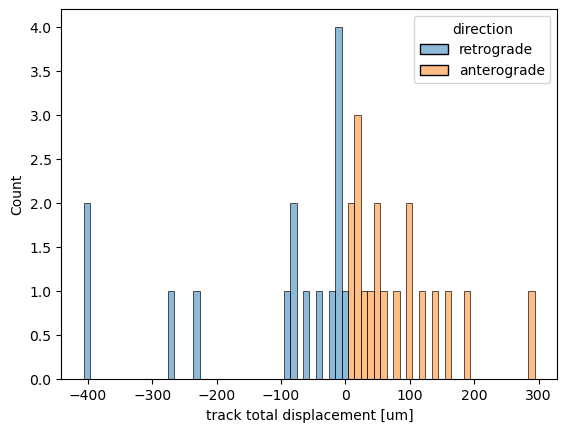

In [7]:
sb.histplot(data=summary, x='track total displacement [um]', stat='count', bins='auto', binwidth=10,
             hue='direction',
                 binrange=None,discrete=None, cumulative=False, common_bins=True,
                 common_norm=True, multiple='layer', element='bars',
                 fill=True, shrink=1, kde=False, kde_kws=None,
                 line_kws=None, thresh=0, pthresh=None, pmax=None,
                 cbar=False, cbar_ax=None, cbar_kws=None, palette=None,
                 hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=None)

- the distribution of the total track displacements for 36 particles

In [8]:
track_cord.drop(columns=[f't [pixel] #{col}' for col in range(1, 36)], inplace=True)

track_diff = track_cord.diff(axis=0)

In [10]:
# retro_track = track_diff.applymap(lambda x: 0 if x>=0 else -1, na_action='ignore')
# antero_track = track_diff.applymap(lambda x: 0 if x<=0 else +1, na_action='ignore')
# pause_track = track_diff.applymap(lambda x: np.nan if x<0 or x>0 else 0, na_action='ignore')

###  We apply a kinematic scheme to determine the motion of the particles of this kymograph,
- First, we obtain transiton probability matrix for all possible states.
- mtm = move to move
- ptm = pause to move
- mtp = move to pause
- ptp = pause to pause

In [12]:
movements = track_diff.applymap(lambda x: 1 if x!=0 else 0, na_action='ignore')

In [13]:

pr_mtm = 0
pr_ptm = 0
pr_ptp = 0  
pr_mtp = 0
num_particles = 0

for col in movements.columns:
    move_to_move = 0
    move_to_pause = 0
    pause_to_move = 0
    pause_to_pause = 0
    
    temp_movements = movements[~movements[col].isna()].reindex()

    for row in temp_movements.index:
        if row == len(temp_movements):
            continue
        else:
            if temp_movements.loc[row, col] == 1 and temp_movements.loc[row+1, col] == 1:
                move_to_move += 1
            elif temp_movements.loc[row, col] == 0 and temp_movements.loc[row+1, col] == 0:
                pause_to_pause +=1
            elif temp_movements.loc[row+1, col] - temp_movements.loc[row, col] > 0:
                pause_to_move += 1
            elif temp_movements.loc[row+1, col] - temp_movements.loc[row, col] < 0:
                move_to_pause += 1
    
    total_transitions = move_to_move + pause_to_pause + pause_to_move + move_to_pause
    try:
        pr_mtm += move_to_move/total_transitions
        pr_ptm += pause_to_move/total_transitions
        pr_ptp += pause_to_pause/total_transitions
        pr_mtp += move_to_pause/total_transitions
    except ZeroDivisionError:
        continue
        
    num_particles += 1

pr_mtm = pr_mtm/num_particles
pr_ptm = pr_ptm/num_particles
pr_ptp = pr_ptp/num_particles 
pr_mtp = pr_mtp/num_particles         

In [14]:
print(f'move-to-move: {pr_mtm}')
print(f'pause-to-move: {pr_ptm}')
print(f'pause-to-pause: {pr_ptp}')
print(f'move-to-pause: {pr_mtp}')

move-to-move: 0.6160993417037025
pause-to-move: 0.12537870149465372
pause-to-pause: 0.13844216720368102
move-to-pause: 0.12007978959796282


In [18]:
# To obtain the transition rates for the movements, 
rate_ptm = -1 * pr_ptm/(pr_ptm + pr_mtp) * np.log(1 - pr_ptm - pr_mtp)
rate_mtp = -1 * pr_mtp/(pr_ptm + pr_mtp) * np.log(1 - pr_ptm - pr_mtp)

In [16]:
rate_ptm

0.1438625431797583

In [17]:
rate_mtp

0.1377824439886215

### Obtain transition rates for the directions $y_{AR}$ and $y_{RA}$

In [17]:
movements = track_diff.applymap(lambda x: 1 if x > 0 else (-1 if x < 0 else 0), na_action='ignore')

In [18]:
pr_atr = 0
pr_rta = 0
num_particles = 0

for col in movements.columns:
    retro_to_antero = 0
    antero_to_retro = 0
    
    temp_movements = movements[~movements[col].isna()].reindex()
    
    for row in temp_movements.index:
        if row==1 or row >= len(temp_movements)-3:
            continue
        else:
            if temp_movements.loc[row, col] == -1 and temp_movements.loc[row+1, col] == 0 and \
                temp_movements.loc[row+2, col] == 0 and temp_movements.loc[row+3, col] == 1:
                retro_to_antero += 1
            elif temp_movements.loc[row, col] == 1 and temp_movements.loc[row+1, col] == 0 and \
                    temp_movements.loc[row+2, col] == 0 and temp_movements.loc[row+3, col] == -1:
                antero_to_retro +=1
    
    total_transitions = antero_to_retro + antero_to_retro
    
    try:
        pr_rta += retro_to_antero/total_transitions
        pr_atr += antero_to_retro/total_transitions
    except ZeroDivisionError:
        continue
        
    num_particles += 1

pr_atr = pr_atr/num_particles
pr_rta = pr_rta/num_particles        

In [19]:
pr_atr

0.5

In [20]:
pr_rta

0.25

### To simulate the positions of the particles using the probabilities gotten above, we solve the ODEs in the paper using RK4 method.

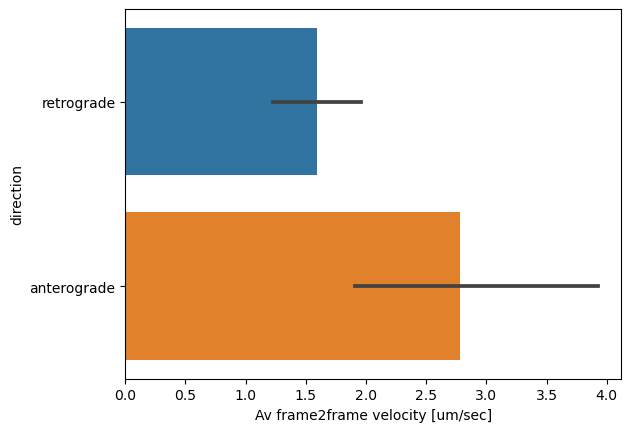

In [21]:
retro_count = (track_diff < 0).sum().sum()
antero_count = (track_diff > 0).sum().sum()
pause_count = (track_diff == 0).sum().sum()
 # get the mean of the average frame to frame velocity           
sb.barplot(data=summary, x="Av frame2frame velocity [um/sec]", y="direction")

#total_count = retro_count + antero_count + pause_count
velo_antero = summary[summary.direction=='anterograde']['Av frame2frame velocity [um/sec]'].mean()
#velo_retro = -1*retro_count/total_count
velo_retro = -1*summary[summary.direction=='retrograde']['Av frame2frame velocity [um/sec]'].mean()


In [28]:
def kinetic_schemes(time, dt, x, velo_antero, velo_retro, state_dir, params, N_particles,
                   retro_dwell_time, antero_dwell_time, pause_dwell_time, antero_run_length, retro_run_length):


    # # Transition Rates and Probability 

    gamma_01 = params['rate_ptm']
    gamma_10 = params['rate_mtp']
    gamma_ar = params['pr_atr']   
    gamma_ra = params['pr_rta']   
    
    # # For Stochastic Simulation 

    p01 = gamma_01 * dt
    p10 = gamma_10 * dt
    p32 = gamma_10 * dt
    p23 = gamma_01 * dt
    p12 = gamma_ar * dt
    p21 = gamma_ra * dt

    for i in range(0, N_particles):
        z = random()
        if state_dir[i] == 0:
            if z < p01:
                state_dir[i] = 1
        elif state_dir[i] == 1:
            if z < p12:
                state_dir[i] = 2
            elif p12 <= z < (p12 + p10):
                state_dir[i] = 0
        elif state_dir[i] == 2:
            if z < p23:
                state_dir[i] = 3
            elif p23 <= z < (p23 + p21):
                state_dir[i] = 1
        elif state_dir[i] == 3:
            if z < p32:
                state_dir[i] = 2
                
        if state_dir[i] == 0:
            x_old = x[i]
            x[i] = x[i] + velo_antero * dt
            x_update = x[i]
            antero_dwell_time[i] = antero_dwell_time[i] + 1
            antero_run_length[i] += x_update - x_old
        elif state_dir[i] == 1:
            x[i] = x[i]
            pause_dwell_time[i] = pause_dwell_time[i] + 1
        elif state_dir[i] == 2:
            x[i] = x[i]
            pause_dwell_time[i] = pause_dwell_time[i] + 1
        elif state_dir[i] == 3:
            x_old = x[i]
            x[i] = x[i] + velo_retro * dt
            x_update = x[i]
            retro_dwell_time[i] = retro_dwell_time[i] + 1
            retro_run_length[i] += x_update - x_old

        #total_dwell_time[i] = retro_dwell_time[i] + antero_dwell_time[i]
            
    return x, state_dir, retro_dwell_time, antero_dwell_time, pause_dwell_time, antero_run_length, retro_run_length


In [30]:
from random import random

t = np.arange(1, 181, 1)
N_particles = 1000
state_direc = np.zeros((N_particles))
init_position = list(np.random.randint(100, high=300, size=N_particles, dtype=int))
#init_position = list(track_cord.loc[0, :].values)
x = np.zeros((N_particles)) + init_position
retro_dwell_time = np.zeros((N_particles))
antero_dwell_time = np.zeros((N_particles))
retro_run_length = np.zeros((N_particles))
antero_run_length = np.zeros((N_particles))
pause_dwell_time = np.zeros((N_particles))
position = np.zeros((len(t), N_particles)) + init_position
dt = 1

params = {'rate_ptm': rate_ptm, 'rate_mtp': rate_mtp, 'pr_atr': pr_atr, 'pr_rta': pr_rta}

for time in t[1:]:
    x, state_direc, retro_dwell_time, antero_dwell_time, pause_dwell_time, antero_run_length, retro_run_length = \
            kinetic_schemes(time, dt, x, velo_antero, velo_retro, state_direc, 
            params, N_particles, retro_dwell_time, antero_dwell_time, pause_dwell_time,
            antero_run_length, retro_run_length)
    position[time-1, :] = x

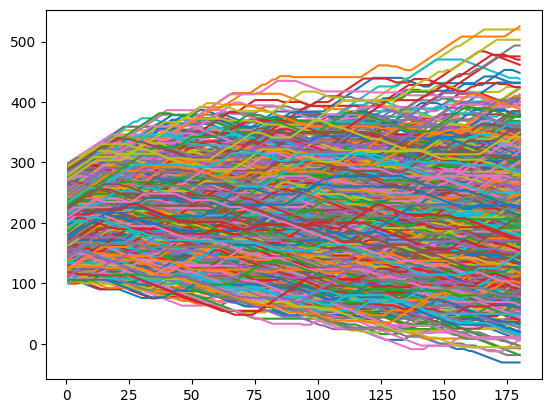

In [31]:
fig, axs = plt.subplots()

for particle in range(N_particles):
    axs.plot(t, position[:, particle])
    
plt.show()

In [32]:
summary_test = pd.DataFrame()
summary_test['track total displacement [um]'] = None
summary_test['track total displacement [um]'] = list(position[-1, :] - position[0, :])
summary_test['direction'] = summary_test.applymap(lambda x: 'anterograde' if x>0 else 'retrograde', na_action='ignore')
summary_test['antero_dwell_time'] = antero_dwell_time
summary_test['retro_dwell_time'] = retro_dwell_time
summary_test['pause_dwell_time'] = pause_dwell_time
summary_test['antero_run_length'] = antero_run_length
summary_test['retro_run_length'] = retro_run_length

Text(0.5, 1.0, 'Experiment')

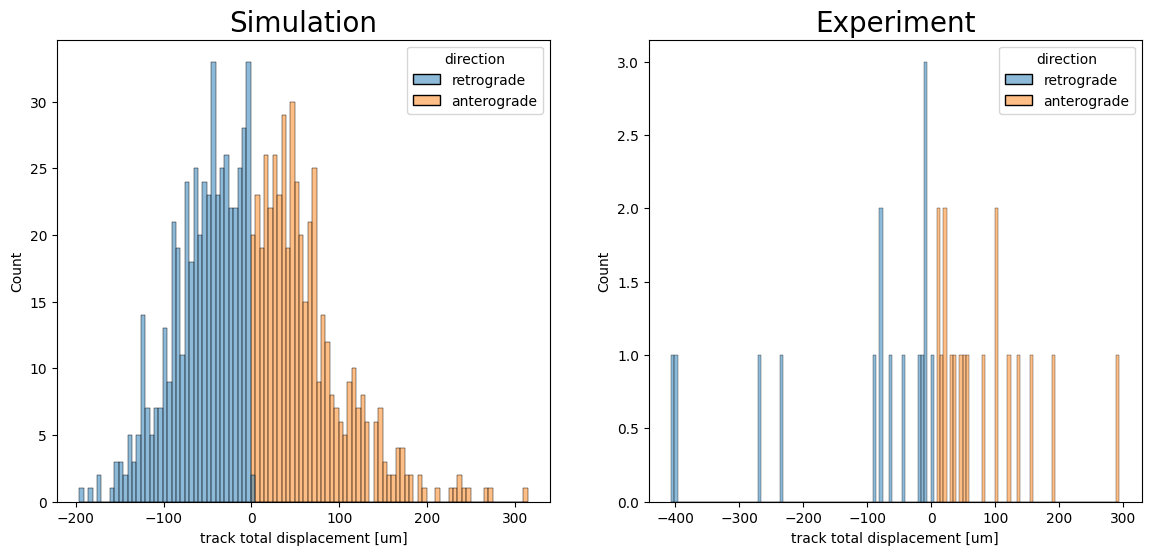

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sb.histplot(data=summary_test, x='track total displacement [um]', stat='count', bins='auto', binwidth=5,
             hue='direction',
                 binrange=None,discrete=None, cumulative=False, common_bins=True,
                 common_norm=True, multiple='layer', element='bars',
                 fill=True, shrink=1, kde=False, kde_kws=None,
                 line_kws=None, thresh=0, pthresh=None, pmax=None,
                 cbar=False, cbar_ax=None, cbar_kws=None, palette=None,
                 hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=axs[0])
axs[0].set_title('Simulation', fontsize=20)
sb.histplot(data=summary, x='track total displacement [um]', stat='count', bins='auto', binwidth=5,
             hue='direction',
                 binrange=None,discrete=None, cumulative=False, common_bins=True,
                 common_norm=True, multiple='layer', element='bars',
                 fill=True, shrink=1, kde=False, kde_kws=None,
                 line_kws=None, thresh=0, pthresh=None, pmax=None,
                 cbar=False, cbar_ax=None, cbar_kws=None, palette=None,
                 hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=axs[1])
axs[1].set_title('Experiment', fontsize=20)


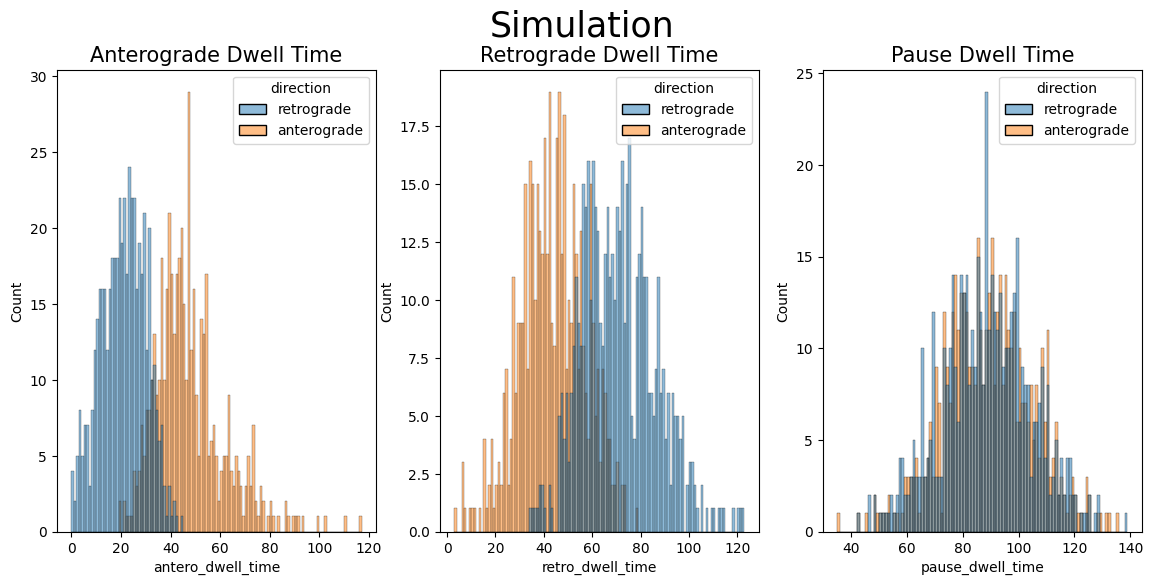

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

sb.histplot(data=summary_test, x='antero_dwell_time', stat='count', bins='auto', binwidth=1,
             hue='direction',
                 binrange=None,discrete=None, cumulative=False, common_bins=True,
                 common_norm=True, multiple='layer', element='bars',
                 fill=True, shrink=1, kde=False, kde_kws=None,
                 line_kws=None, thresh=0, pthresh=None, pmax=None,
                 cbar=False, cbar_ax=None, cbar_kws=None, palette=None,
                 hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=axs[0])
axs[0].set_title('Anterograde Dwell Time', fontsize=15)

sb.histplot(data=summary_test, x='retro_dwell_time', stat='count', bins='auto', binwidth=1,
             hue='direction',
                 binrange=None,discrete=None, cumulative=False, common_bins=True,
                 common_norm=True, multiple='layer', element='bars',
                 fill=True, shrink=1, kde=False, kde_kws=None,
                 line_kws=None, thresh=0, pthresh=None, pmax=None,
                 cbar=False, cbar_ax=None, cbar_kws=None, palette=None,
                 hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=axs[1])
axs[1].set_title('Retrograde Dwell Time', fontsize=15)

sb.histplot(data=summary_test, x='pause_dwell_time', stat='count', bins='auto', binwidth=1,
             hue='direction',
                 binrange=None,discrete=None, cumulative=False, common_bins=True,
                 common_norm=True, multiple='layer', element='bars',
                 fill=True, shrink=1, kde=False, kde_kws=None,
                 line_kws=None, thresh=0, pthresh=None, pmax=None,
                 cbar=False, cbar_ax=None, cbar_kws=None, palette=None,
                 hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=axs[2])
axs[2].set_title('Pause Dwell Time', fontsize=15)

plt.suptitle('Simulation', fontsize=25)

plt.show()

Text(0.5, 1.0, 'Retrograde Run Length')

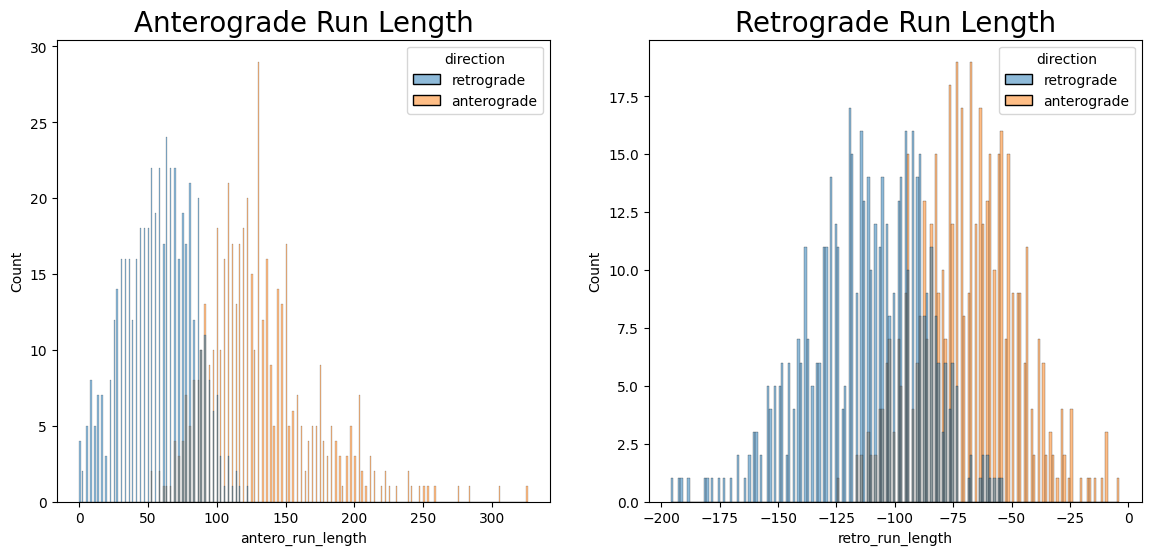

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sb.histplot(data=summary_test, x='antero_run_length', stat='count', bins='auto', binwidth=1,
             hue='direction',
                 binrange=None,discrete=None, cumulative=False, common_bins=True,
                 common_norm=True, multiple='layer', element='bars',
                 fill=True, shrink=1, kde=False, kde_kws=None,
                 line_kws=None, thresh=0, pthresh=None, pmax=None,
                 cbar=False, cbar_ax=None, cbar_kws=None, palette=None,
                 hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=axs[0])
axs[0].set_title('Anterograde Run Length', fontsize=20)

sb.histplot(data=summary_test, x='retro_run_length', stat='count', bins='auto', binwidth=1,
             hue='direction',
                 binrange=None,discrete=None, cumulative=False, common_bins=True,
                 common_norm=True, multiple='layer', element='bars',
                 fill=True, shrink=1, kde=False, kde_kws=None,
                 line_kws=None, thresh=0, pthresh=None, pmax=None,
                 cbar=False, cbar_ax=None, cbar_kws=None, palette=None,
                 hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=axs[1])
axs[1].set_title('Retrograde Run Length', fontsize=20)

plt.suptitle('Simulation', fontsize=25)